# CAT GPLVM for MNIST

Next time ill put all the helper functions in a .py file but for now run the cell below and hide it to make your life good.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc("text", usetex=False)
rc("font", family = "serif")
rc("figure",figsize=(9,6))
rc("figure",facecolor="white")
%config InlineBackend.figure_format = 'retina'

import os
import time
from sklearn.utils import shuffle
#import sklearn.datasets as datasets
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro import poutine
import torch
from torchvision import datasets
from torch.nn import Parameter
import pyro.ops.stats as stats
from sklearn.manifold import Isomap

In [9]:
from pyro_gp_utils import plot2dproj, plot_before_after

In [10]:
def train_binary(gpmodel, X_test, Y_test, nsteps=2000, lr=0.0025,cuda=True):
    opt = torch.optim.Adam(gpmodel.parameters(), lr=0.0025)
    loss_fn = pyro.infer.TraceMeanField_ELBO().differentiable_loss
    losses = []
    bce = torch.nn.BCELoss(reduction='mean')
    bce_losses = []
    
    if cuda:
        X_test = X_test.cuda()
        Y_test = Y_test.cuda()
        
    for i in range(nsteps):
            opt.zero_grad()
            loss = loss_fn(gpmodel.model, gpmodel.guide)
            loss.backward()
            opt.step()
            losses.append(loss.item())
            # Show some output
            if (i+1)%100==0:
                with torch.no_grad():
                    f_loc, f_var = gpmodel(X_test)
                    probs = dist.Normal(f_loc, f_var)().sigmoid()
                    bce_losses.append(torch.nn.BCELoss()(probs.t(),Y_test))
                print(f'{i+1}: Accuracy = {test_binary(gpmodel,X_test,Y_test,cuda):0.5f} -- BCELoss = {bce_losses[-1]:0.5f}',end='\r')
            if (i+1)==nsteps:
                print("\n")
    return losses

In [11]:
def test_binary(gpmodel, X_test, Y_test, cuda):
    if isinstance(gpmodel.likelihood, gp.likelihoods.Binary):
        with torch.no_grad():
            if cuda:
                X_test, Y_test = X_test.cuda(), Y_test.cuda()
            f_loc, f_var = gpmodel(X_test)
            pred = gpmodel.likelihood(f_loc,f_var)
            return (100.*pred.eq(Y_test.t()).detach().cpu().sum()/Y_test.nelement()).item()

In [12]:
def batch_train(gpmodel, cuda, X_train, Y_train, X_test, Y_test, 
                loss_fn=pyro.infer.TraceMeanField_ELBO().differentiable_loss, optimizer=torch.optim.Adam, lr=0.0025,
                num_epochs=20, num_steps=200, batch_size=1000):
    opt = optimizer(gpmodel.parameters(), lr=lr)
    losses = [] 
    for e in range(num_epochs):
        # Set the batch
        batch_idx = torch.randperm(X_train.shape[1])[:batch_size]
        #x_batch = X_train[batch_idx]
        y_batch = Y_train[:,batch_idx]
        if cuda: y_batch = y_batch.cuda()
        gpmodel.y = y_batch.t()
        #Take the steps
        for i in range(num_steps):
            opt.zero_grad()
            loss = loss_fn(gpmodel.model, gpmodel.guide)
            loss.backward()
            opt.step()
            losses.append(loss.item())
        # Show some output
        print(f'Epoch {e+1} -- Accuracy = {test_binary(gpmodel,X_test,Y_test,cuda)} -- Loss = {losses[-1]}',end='\r')
    return losses

In [13]:
mnist = datasets.MNIST("./data", download=True)

In [14]:
N=5000
data = (mnist.train_data[:N].reshape(N,28*28)>0).to(torch.float)
labels = mnist.train_labels[:N]
# fours = data[mnist.targets[N]==4]
U, S, V = data.svd()
data_pcs = U.mm(torch.diag(S)[:,:2])

Isomap for the "fours" dataset is useless, just initialize the latent points from the prior $\mathcal{N}(0,I)$

In [7]:
x_iso = Isomap().fit_transform(data)

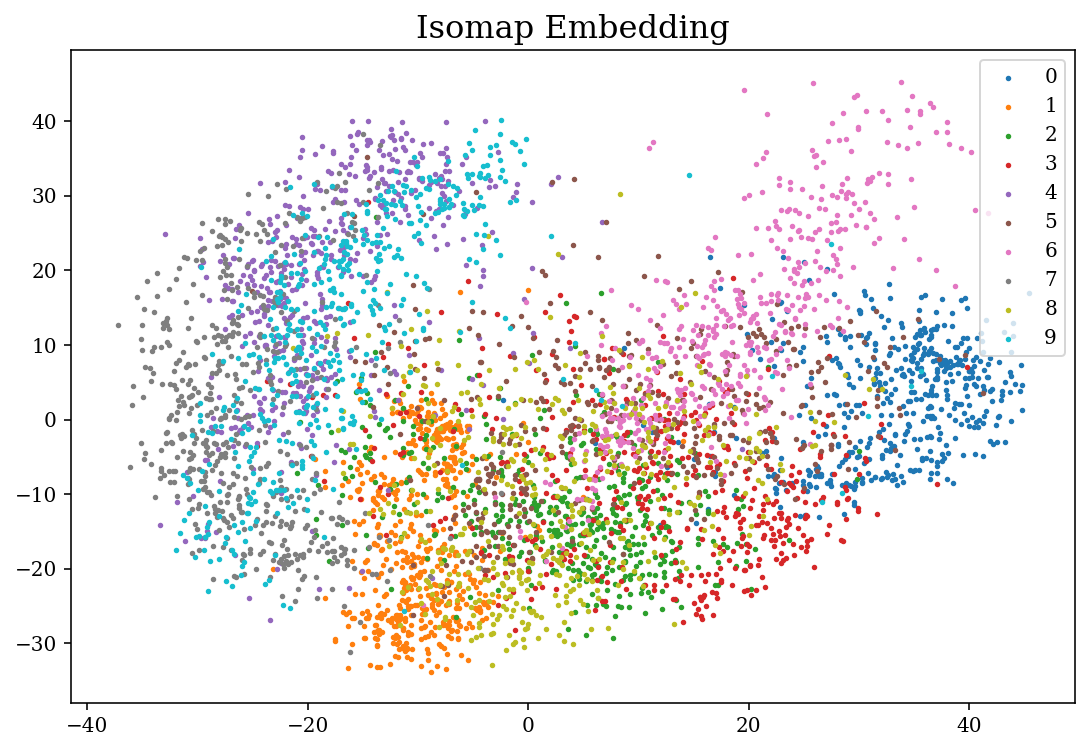

In [12]:
plot2dproj(x_iso, labels, 'Isomap', legend=True)

In [9]:
#Set up training data
latent_dim=2
Y = data.to(torch.get_default_dtype())
X_init = data_pcs[:,:latent_dim].to(torch.get_default_dtype())
X = X_init #Parameter(X_init) #This line makes it a GPLVM
n_test = 200
X_test = X_init[-n_test:]
Y_test = Y[-n_test:]

In [10]:
#Set up kernel
rbf =  gp.kernels.RBF(input_dim=latent_dim,lengthscale = X.max(0)[0] - X.mean(0))
m12 = gp.kernels.Exponential(input_dim=latent_dim,lengthscale = X.max(0)[0] - X.mean(0))
m32 = gp.kernels.Matern32(input_dim=latent_dim,lengthscale = X.max(0)[0] - X.mean(0))
m52 = gp.kernels.Matern52(input_dim=latent_dim,lengthscale = X.max(0)[0] - X.mean(0))
K = rbf
# K = gp.kernels.Sum(K,m12)
# K = gp.kernels.Sum(K,m32)
# K = gp.kernels.Sum(K,m52)

#Set up likelihood
likelihood = gp.likelihoods.Binary()

#Set up inducing points by downsampling the training data
n_inducing = 100
inds = torch.randperm(X_init.shape[0])[:n_inducing]
Xu = X_init[inds]
yu = Y[inds]

In [21]:
print(X.shape)
print(Y.shape)

torch.Size([5000, 2])
torch.Size([5000, 784])


In [22]:
pyro.clear_param_store()

In [23]:
#Set up the model
gpc = gp.models.VariationalSparseGP(X=X.cuda(), y=Y.t().cuda(), kernel=K, Xu=Xu, likelihood=likelihood,
                                    jitter=1e-3, whiten=True, num_data = X.shape[0]).cuda()

In [24]:
loc, scale = gpc(X_test.cuda())
pred = gpc.likelihood(loc, scale).t().cpu()

In [25]:
# fig, ax = plt.subplots(1,2,figsize=(16,10))
# ax[0].imshow(Y_test[0].reshape(28,28).numpy())
# ax[1].imshow(pred[0].reshape(28,28).numpy())
# plt.show()

In [26]:
losses = train_binary(gpc, X_test, Y_test, nsteps=100)

100: Accuracy = 56.95280 -- BCELoss = 0.57472



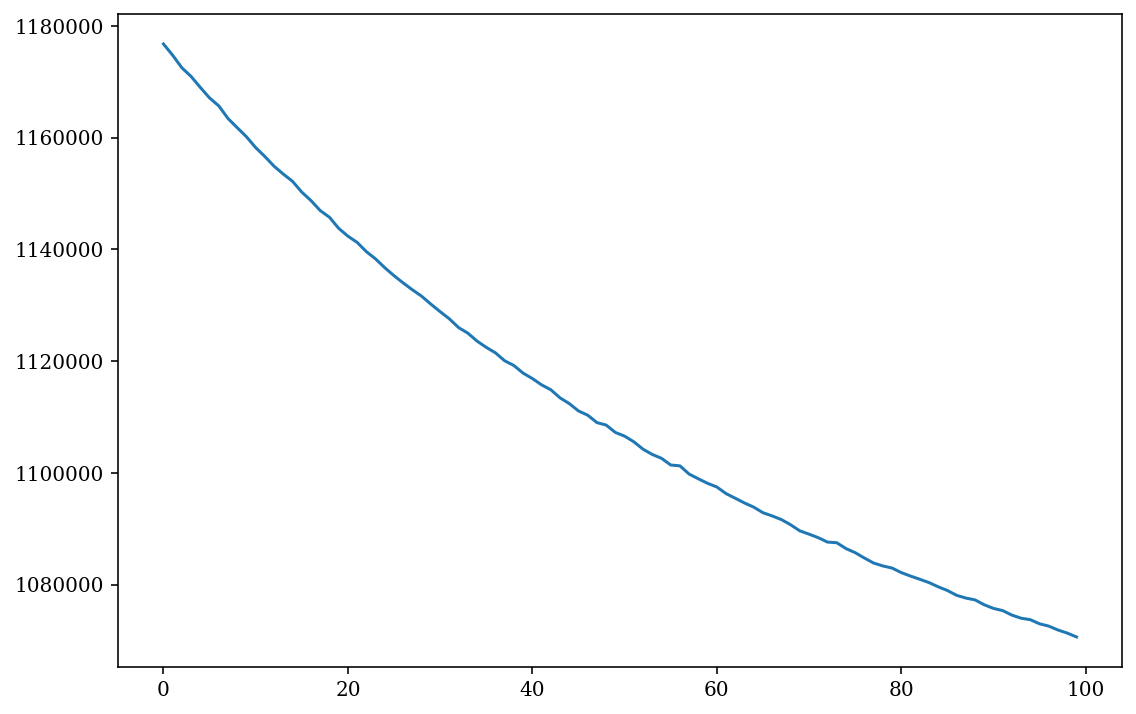

In [19]:
plt.plot(losses)
plt.show()

In [ ]:
# for n in range(5):
#     fig, ax = plt.subplots(1,2,figsize=(16,10))
#     ax[0].imshow(Y_test[n].reshape(28,28).numpy())
#     ax[1].imshow(loc[:,n].cpu().sigmoid().reshape(28,28).detach().numpy())
#     plt.show()

In [59]:
#Set up training data
#torch.set_default_dtype(torch.float)
latent_dim=2
Y = data.to(torch.get_default_dtype())
X_init = torch.tensor(x_iso[:,:latent_dim]).to(torch.get_default_dtype())
X_init = (X_init - X_init.mean(0))/X_init.std(0)
#X_init = data_pcs[:,:latent_dim].to(torch.get_default_dtype())
n_test = 200
X_test = X_init[-n_test:]
Y_test = Y[-n_test:]

In [60]:
#Set up kernel
l0 = X_init.max(0)[0] - X_init.mean(0)
rbf =  gp.kernels.RBF(input_dim=latent_dim,lengthscale = l0)
m12 = gp.kernels.Exponential(input_dim=latent_dim,lengthscale = l0)
m32 = gp.kernels.Matern32(input_dim=latent_dim,lengthscale = l0)
m52 = gp.kernels.Matern52(input_dim=latent_dim,lengthscale = l0)
wn = gp.kernels.WhiteNoise(input_dim=latent_dim)
K = rbf
K = gp.kernels.Sum(K,m12)
K = gp.kernels.Sum(K,m32)
K = gp.kernels.Sum(K,m52)
K = gp.kernels.Sum(K,wn)

#Set up likelihood
likelihood = gp.likelihoods.Binary()

#Set up inducing points by downsampling the training data
n_inducing = 100
inds = torch.randperm(X_init.shape[0])[:n_inducing]
Xu = X_init[inds]
yu = Y[inds]

#Set up latent Xs as parameter


In [61]:
# gpc = gp.models.VariationalSparseGP(X=X.cuda(), y=Y.t().cuda(), kernel=K, Xu=Xu, likelihood=likelihood,
#                                     jitter=1e-3, whiten=True, num_data=X.shape[0]).cuda()#Set up the model
#X = Parameter(X_init.clone()).cuda()
pyro.clear_param_store()
gplvm = gp.models.VariationalSparseGP(X=X_init.cuda(), y=Y.t().cuda(), kernel=K, Xu=Xu, likelihood=likelihood,
                                      whiten=True, num_data=X.shape[0])
gplvm.X = pyro.nn.PyroSample(dist.Normal(gplvm.X.new_zeros(gplvm.X.shape), 1.).to_event())
gplvm.autoguide("X", dist.Normal)
gplvm = gplvm.cuda()

In [44]:
# trace = poutine.trace(gplvm.model).get_trace()
# trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
# print(trace.format_shapes())

In [62]:
losses = train_binary(gplvm, X_test, Y_test, nsteps=1000)

1000: Accuracy = 78.44260 -- BCELoss = 0.33761



In [70]:
pyro.get_param_store()['lengthscale']

KeyError: 'lengthscale'

In [77]:
torch.Size([2])==2

False

In [78]:
for p in gplvm.parameters():
    if p.shape==torch.Size([2]):
        print(p)

Parameter containing:
tensor([1.2479, 1.5953], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([2.1743, 2.4925], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([1.4651, 1.6595], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([1.2631, 1.5154], device='cuda:0', requires_grad=True)


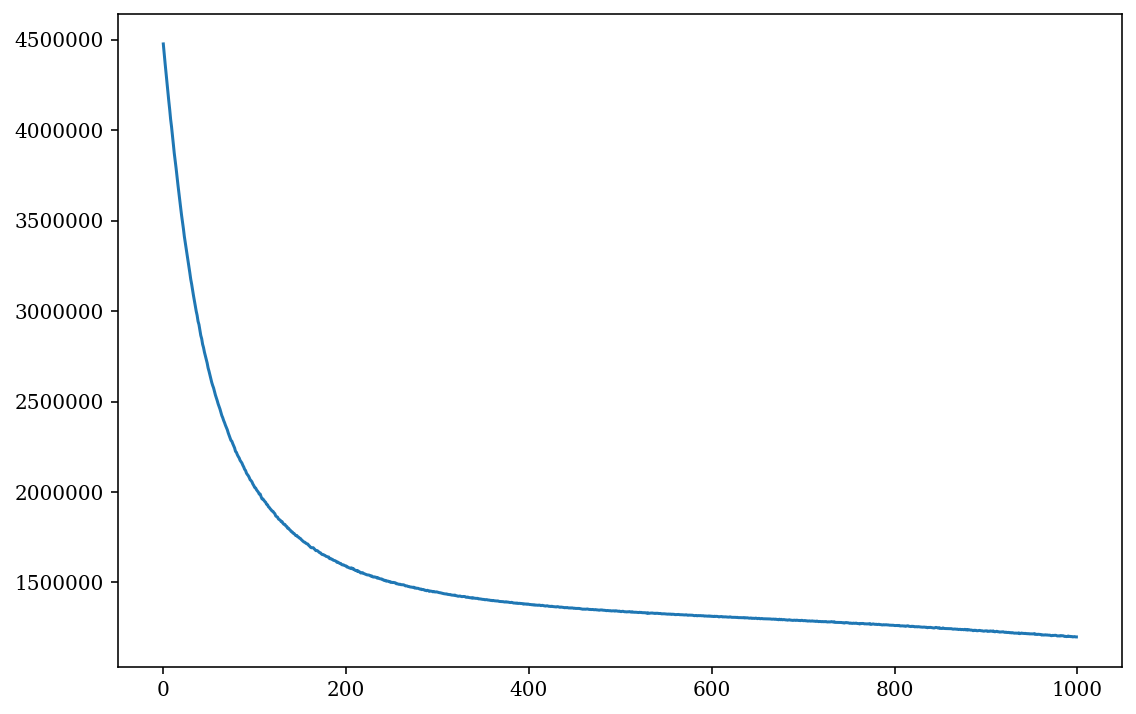

In [64]:
plt.plot(losses)
plt.show()

In [65]:
# start = time.process_time()
# losses = train_binary(gplvm, X_test, Y_test, nsteps=1000)
# stop = time.process_time()
# print(f'Elapsed Time to Train: {stop-start}')

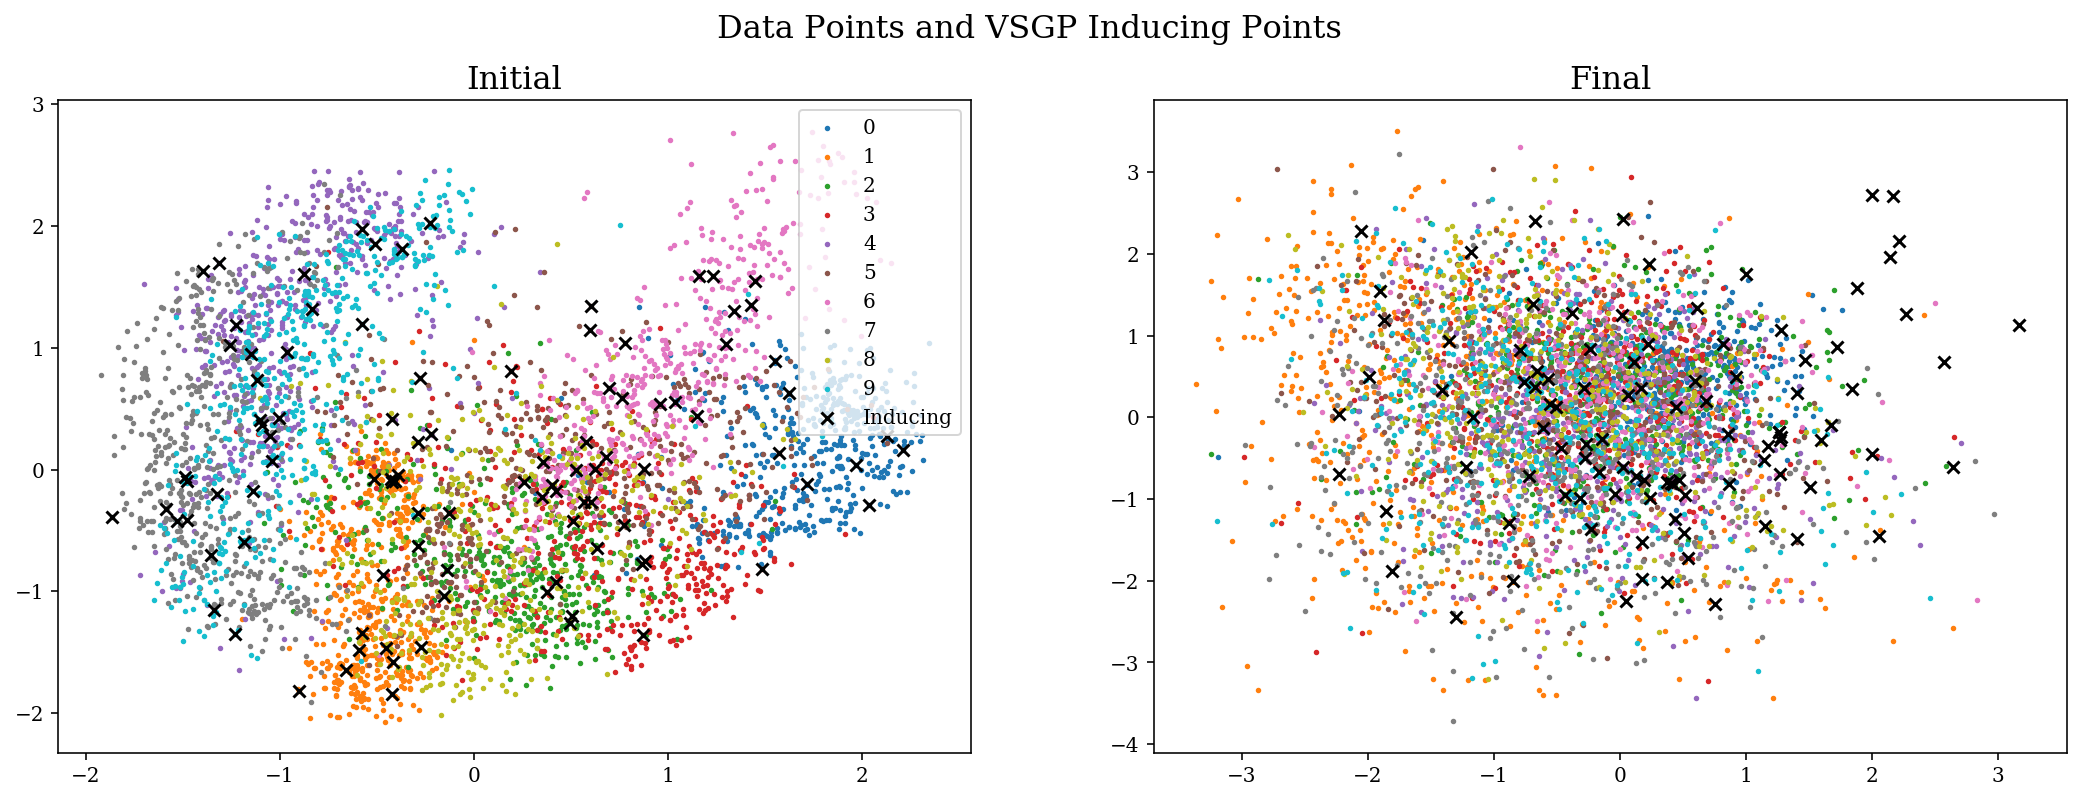

In [66]:
plot_before_after(X_init.numpy(),gplvm.X.clone().detach().cpu().numpy(),
                  Xu, gplvm.Xu.clone().detach().cpu().numpy(),labels.numpy(),legend=True)

Might use a smoother kerner to get more normal clusters but this seemed to work fine albeit slower than the GrandPrix people say it should. Could be because of the non-gaussian likelihood but unclear. Should time the training next time. Also should try just initializing with samples from normal distribution because pca seems pretty useless.

In [ ]:
loc, scale = gplvm(X_test.cuda())
idx = np.random.choice(np.arange(n_test),size=5,replace=False)
for n in idx:
    fig, ax = plt.subplots(1,2,figsize=(16,10))
    ax[0].imshow(Y_test[n].reshape(28,28).numpy())
    ax[1].imshow(loc[:,n].cpu().sigmoid().reshape(28,28).detach().numpy())
    plt.show()

So this is neat and I understand the limits of this GPU now. The embedding isnot quite as good as I would have hoped (i guess that whats happens when you start with a bad embedding). Also feels like were hitting up against the whole "image processing is hard without convolutions" barrier.

In [15]:
fours = mnist.train_data[mnist.train_labels==4]
print(fours.shape)
fours = fours.reshape(fours.shape[0],-1).t()>0
print(fours.shape)

torch.Size([5842, 28, 28])
torch.Size([784, 5842])


So now the `fours` dataset is oriented such that each point in the latent space will represent a single pixel (like a residue) and we can regress from latent space to the probability distribution over the assignment of that pixel?

In [16]:
#Set up training data
#torch.set_default_dtype(torch.float)
latent_dim=3
Y = fours.to(torch.get_default_dtype())

U, S, V = Y.svd()
#X_init = U.mm(torch.diag(S)[:,:latent_dim]).to(torch.get_default_dtype())
#X_init = torch.random((Y.shape[0],latent_dim))
X_init = dist.Laplace(torch.zeros(latent_dim),1).sample([Y.shape[0]])

# No real testing data here, were just trying learn a good embedding = but use anyway for BCE Loss purposes
n_test = 200
X_test = X_init[-n_test:]
Y_test = Y[-n_test:]

#Set up kernel parameters
l0 = X_init.max(0)[0] - X_init.mean(0)

#Set up likelihood
likelihood = gp.likelihoods.Binary()

#Set up inducing points by downsampling the training data
n_inducing = 50
inds = torch.randperm(X_init.shape[0])[:n_inducing]
Xu = X_init[inds]
yu = Y[inds]

#Set up latent Xs as parameter
#X = Parameter(X_init)

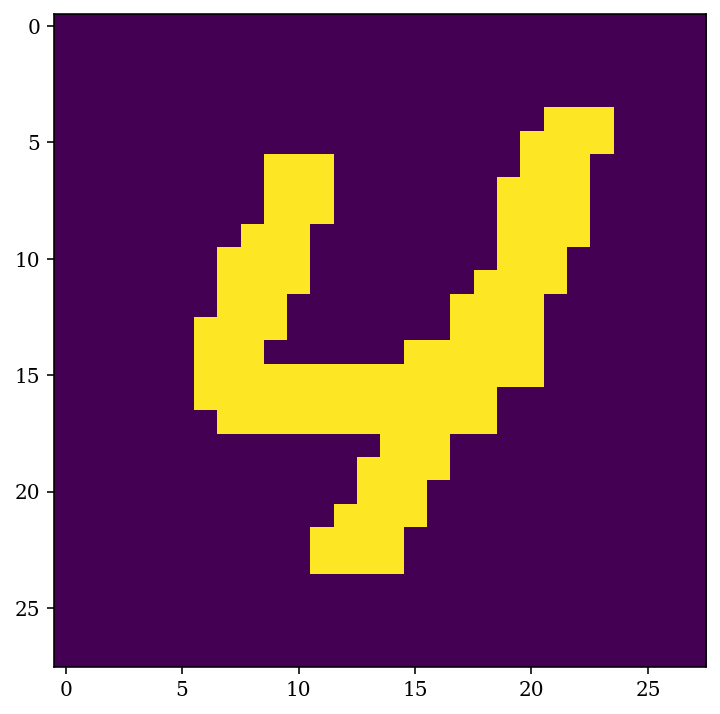

In [17]:
plt.imshow(Y[:,50].cpu().numpy().reshape(28,28))
plt.show()

In [18]:
#Set up the model
pyro.clear_param_store()
gplvm = gp.models.VariationalSparseGP(X=X_init.cuda(), y=Y.t().cuda(), kernel=gp.kernels.RBF(input_dim=latent_dim,lengthscale=l0),
                                      Xu=Xu,likelihood=likelihood,jitter=0.1, whiten=True)
gplvm.X = pyro.nn.PyroSample(dist.Laplace(gplvm.X.new_zeros(gplvm.X.shape), 1).to_event())
gplvm.autoguide("X", dist.MultivariateNormal)
lengthscale_prior = dist.Gamma(2*torch.arange(1., latent_dim+1 ,device='cuda'), 0.25).to_event()
gplvm.kernel.lengthscale = pyro.nn.PyroSample(lengthscale_prior)
#gplvm.kernel.autoguide("lengthscale", dist.Delta)
gplvm = gplvm.cuda()

In [59]:
print(X_init.shape)
print(Y.shape)

torch.Size([784, 3])
torch.Size([784, 5842])


In [19]:
losses = train_binary(gplvm,X_test,Y_test,nsteps=4000)

4000: Accuracy = 76.17751 -- BCELoss = 1.22620



In [60]:
torch.cuda.empty_cache()

In [176]:
# losses = batch_train(gplvm, True, X, Y, X_test, Y_test, num_epochs=10, num_steps=200)

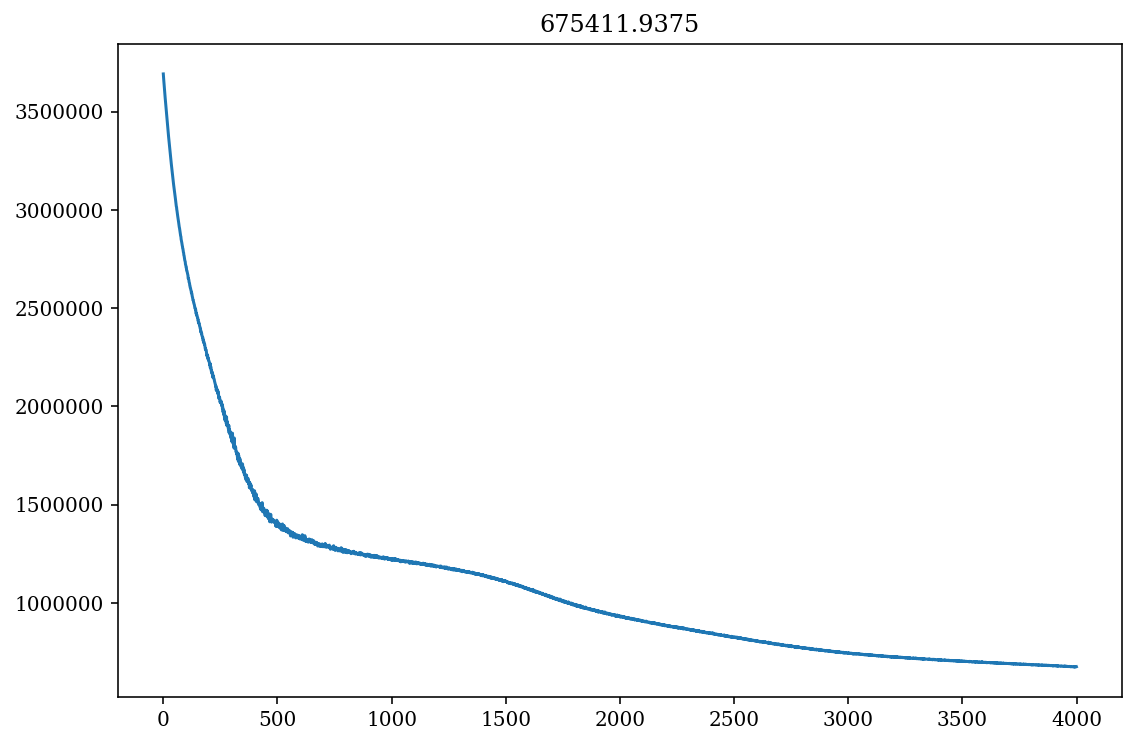

In [21]:
plt.plot(losses)
plt.title(losses[-1])
plt.show()

In [24]:
Xi, Xf, Xui, Xuf =  X_init.numpy(), gplvm.X_loc.clone().detach().cpu().numpy(), Xu.detach().numpy(), gplvm.Xu.clone().detach().cpu().numpy()
combinations = np.array([[0,1],[0,2],[1,2]])

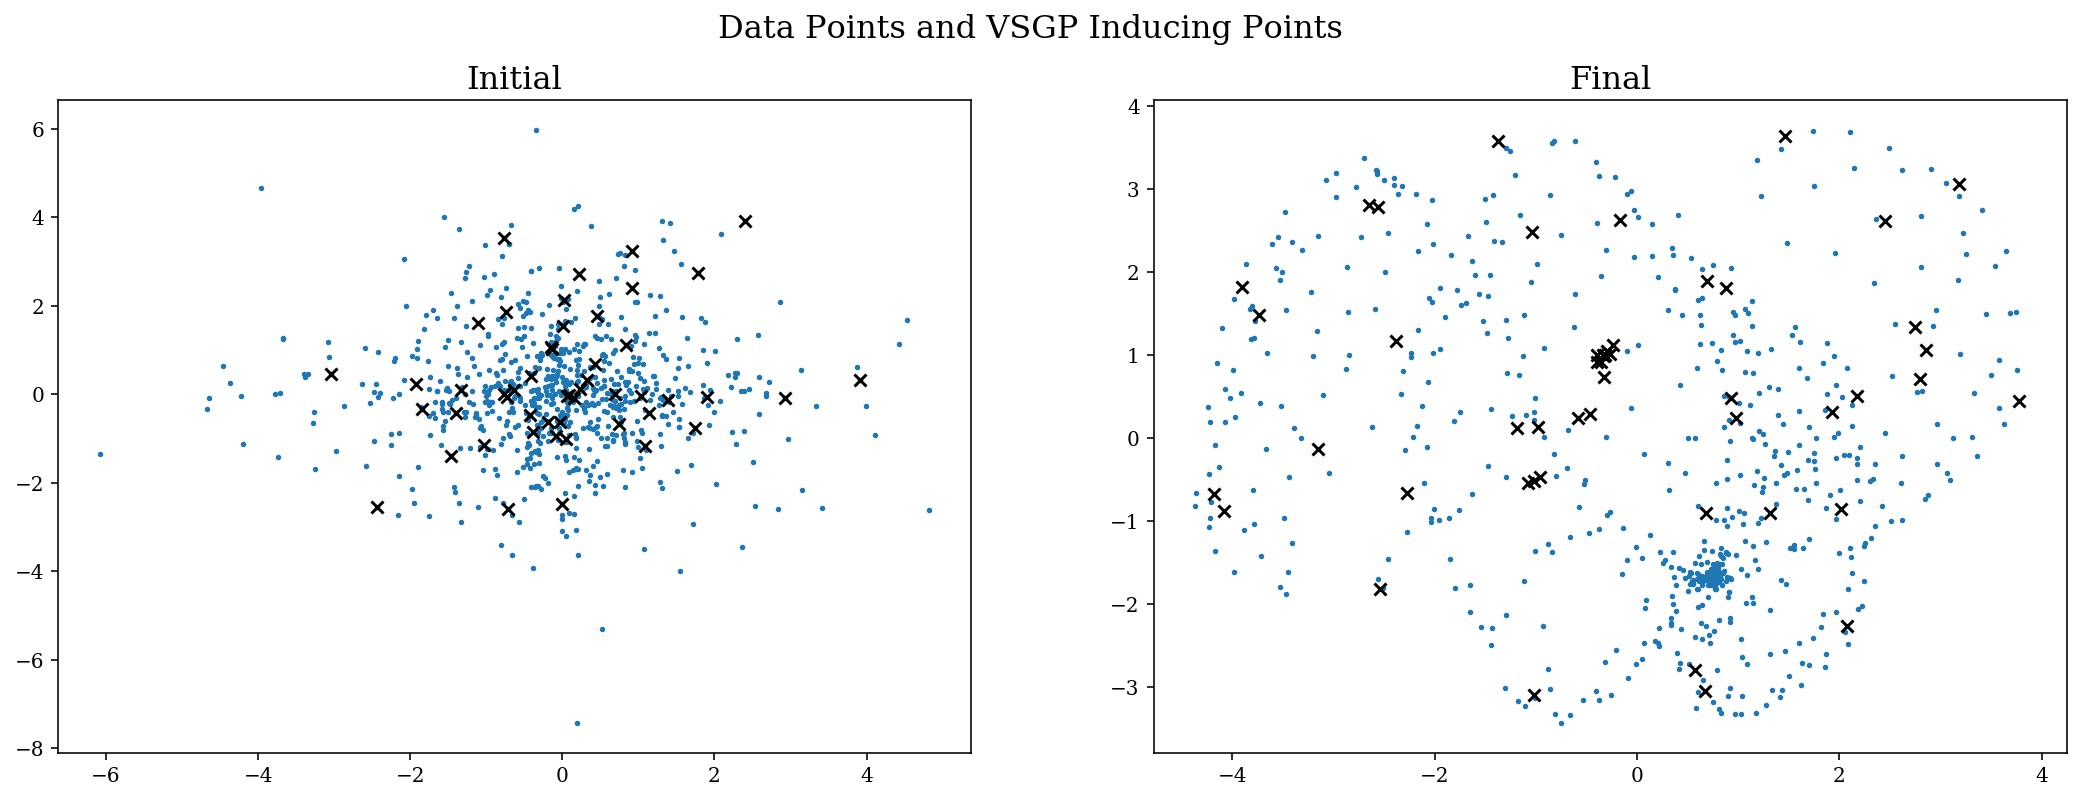

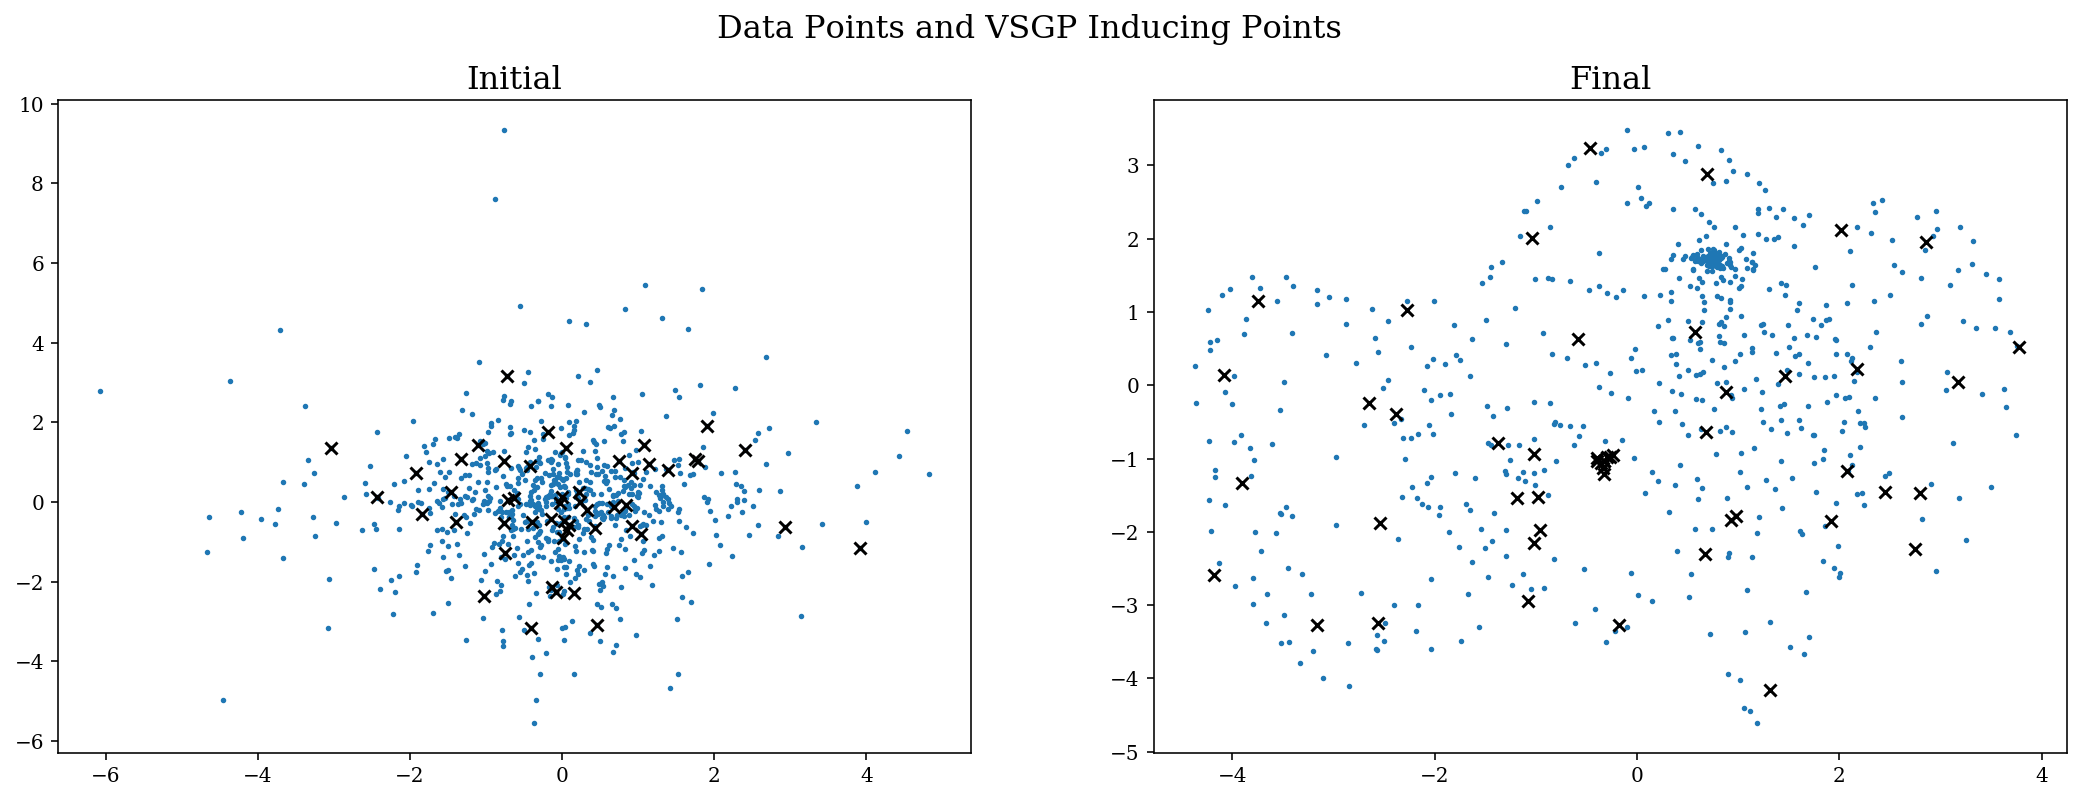

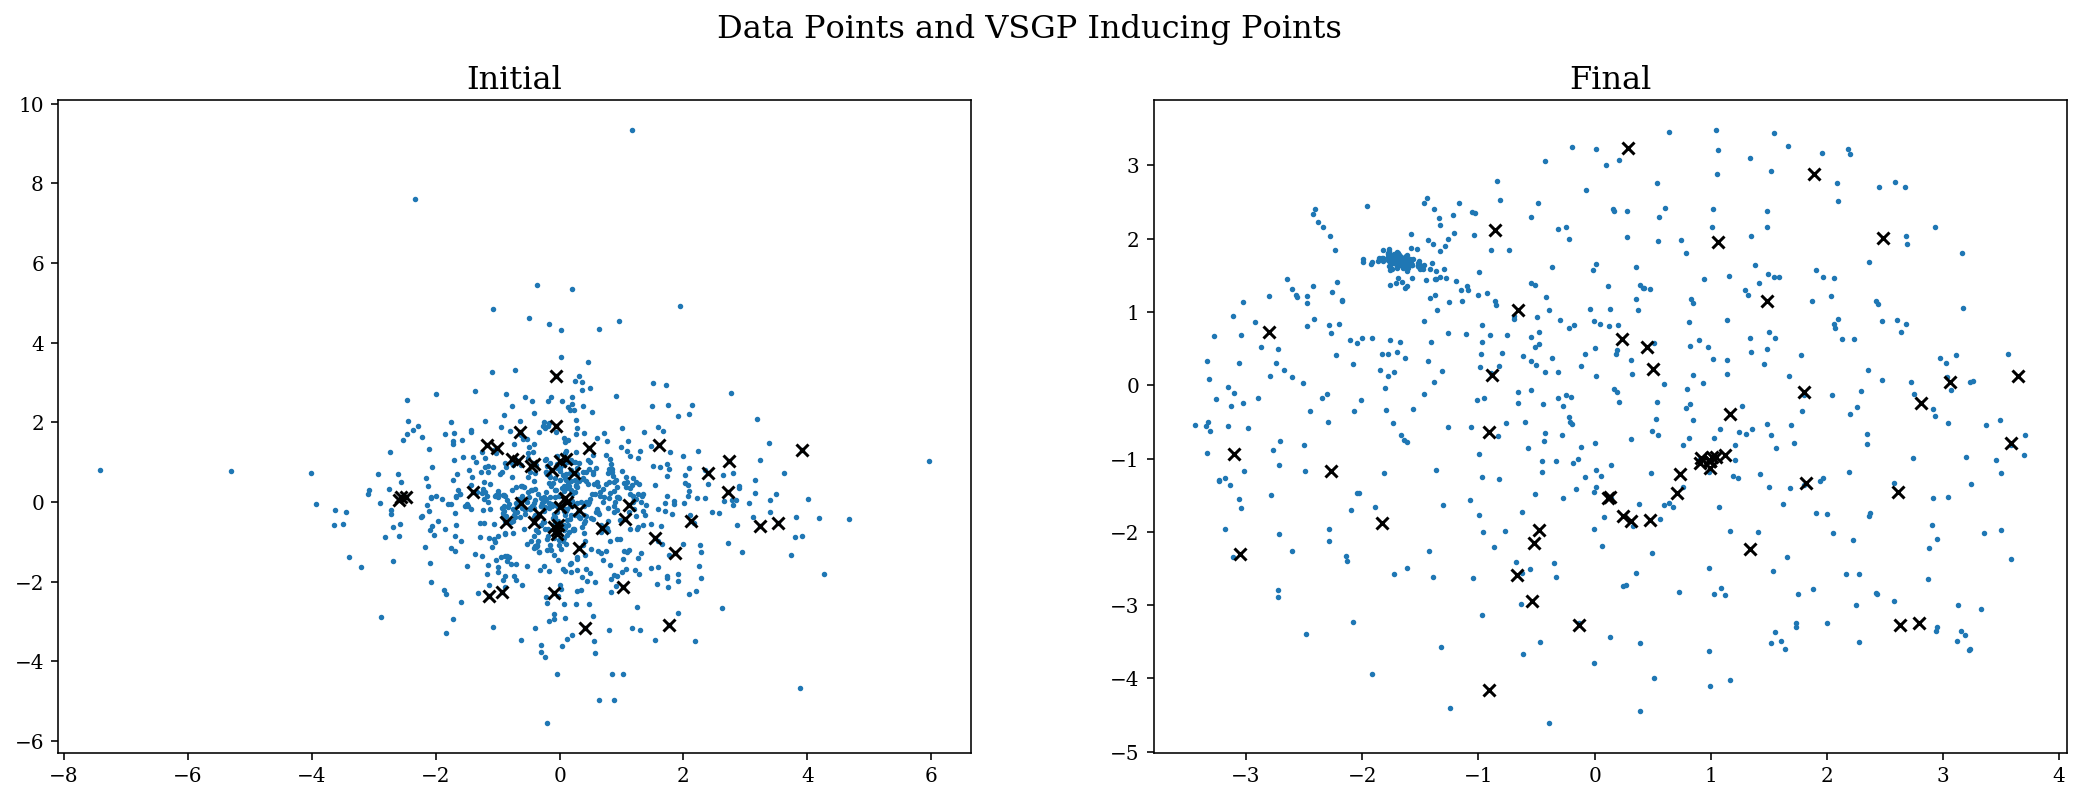

In [33]:
for c in combinations:
    plot_before_after(Xi[:,c], Xf[:,c], Xui[:,c], Xuf[:,c], labels=np.zeros(Xi.shape[0]))

In [50]:
Xf.mean(axis=0)

array([ 0.23509464, -0.5573722 ,  0.46749252], dtype=float32)

In [57]:
big_cluster = np.zeros_like(Xf)

In [56]:
for i in range(3):
    counts, edges = np.histogram(Xf[:,0],bins=50)

In [54]:
Xf.shape

(784, 3)

In [49]:
amax = np.argmax(counts)
np.mean(edges[amax:amax+2])

0.75207883

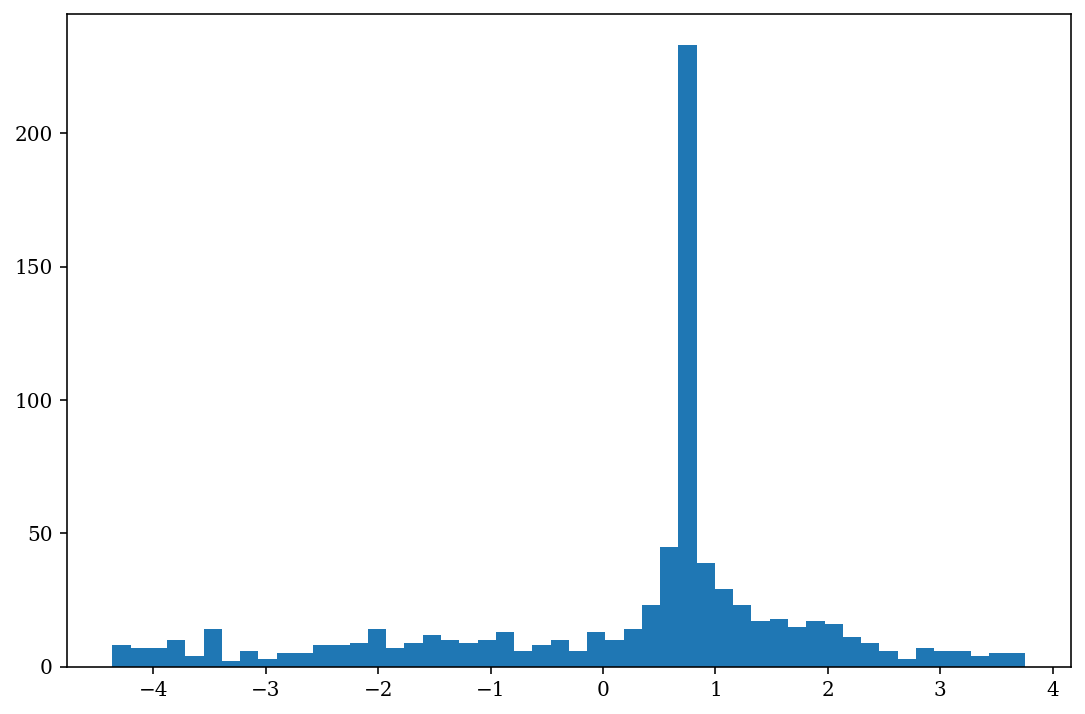

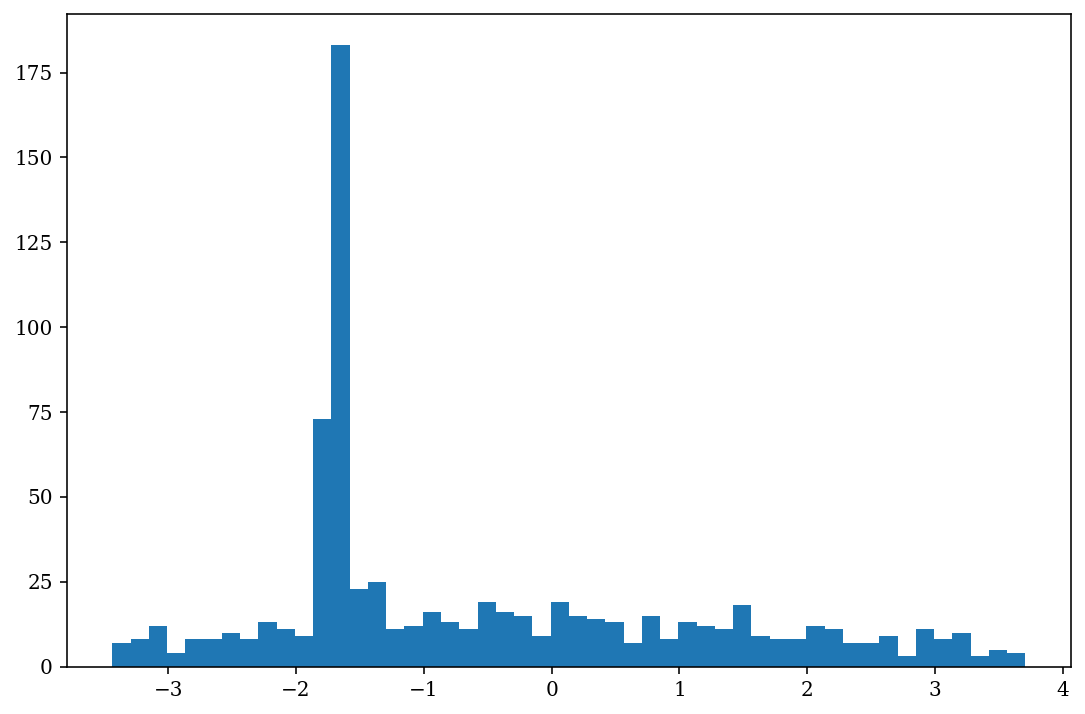

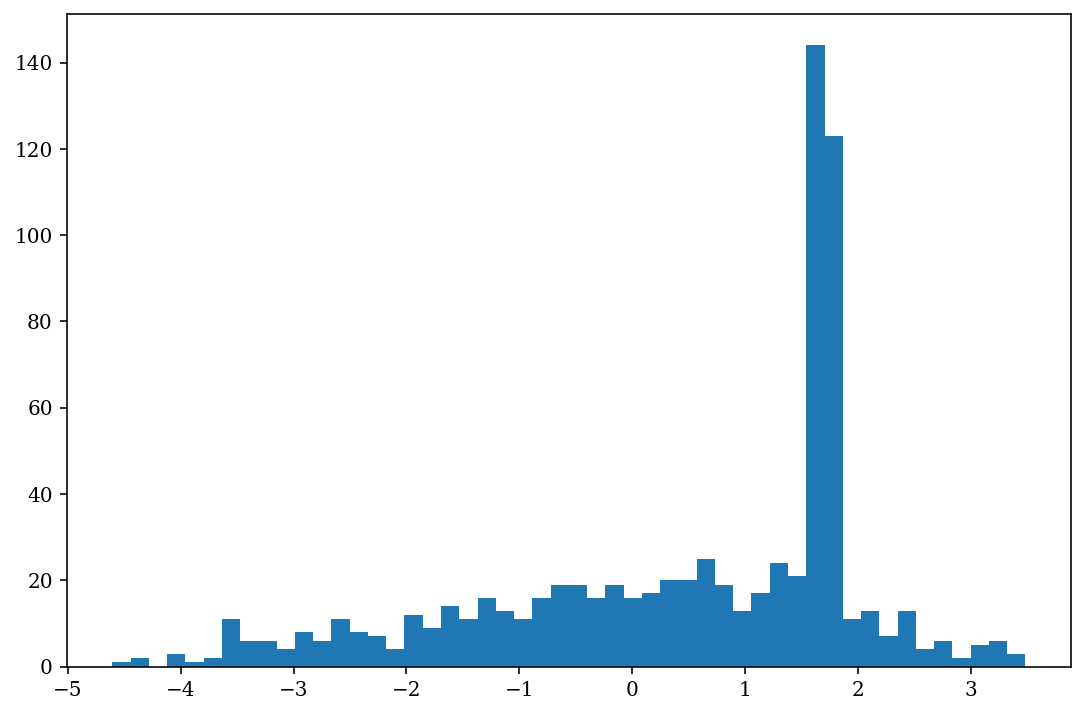

In [43]:
for i in range(latent_dim):
    plt.hist(Xf[:,i], bins=50)
    plt.show()

In [200]:
gplvm.X_loc.shape

torch.Size([784, 2])

In [36]:
gplvm.kernel.lengthscale

tensor([2.0843, 3.2619, 3.4331], device='cuda:0', grad_fn=<ExpandBackward>)

In [34]:
Xin = X_init.numpy()
Xout = gplvm.X_loc.clone().detach().cpu().numpy()

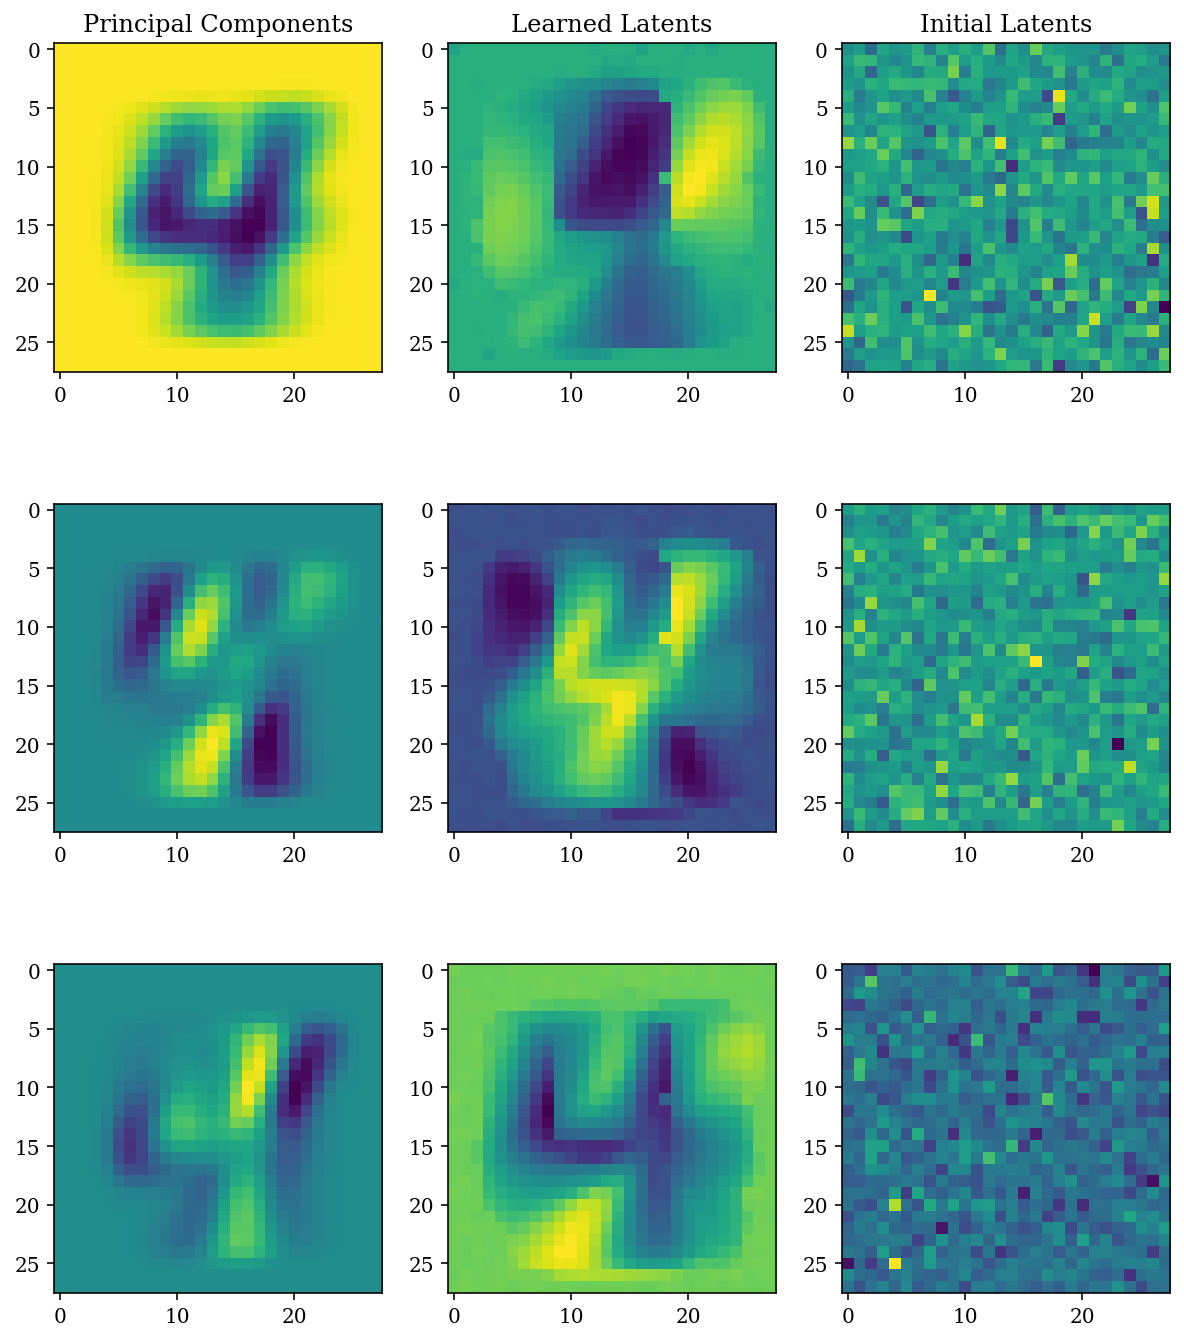

In [35]:
pcs =  U.mm(torch.diag(S)[:,:10]).numpy()
fig, ax = plt.subplots(latent_dim,3,figsize=(10,int(4*latent_dim)))
for i in range(latent_dim):
    ax[i,0].imshow(pcs[:,i].reshape(28,28))
    ax[i,1].imshow(Xout[:,i].reshape(28,28))
    ax[i,2].imshow(Xin[:,i].reshape(28,28))
    if i==0:
        ax[i,0].set_title("Principal Components")
        ax[i,1].set_title("Learned Latents")
        ax[i,2].set_title("Initial Latents")
#plt.savefig('cgplvm.png',dpi=200)    
plt.show()

In [202]:
for p in gplvm.named_parameters():
    print(p[0])

Xu
u_loc
u_scale_tril_unconstrained
X_loc
X_scale_unconstrained
kernel.variance_unconstrained
kernel.lengthscale_map_unconstrained


In [21]:
gplvm.kernel.lengthscale

tensor([4.6806, 4.3001, 5.1847, 3.9282, 4.4882], device='cuda:0',
       grad_fn=<ExpandBackward>)

In [27]:
loc,scale = gplvm(gplvm.X)
out = gplvm.likelihood(loc,scale)

In [30]:
sigmoid = torch.nn.Sigmoid()

In [31]:
#out = out[:10].detach().cpu().numpy().reshape(10,28,28)
prob = sigmoid(loc[:10]).detach().cpu().numpy().reshape(-1,28,28)

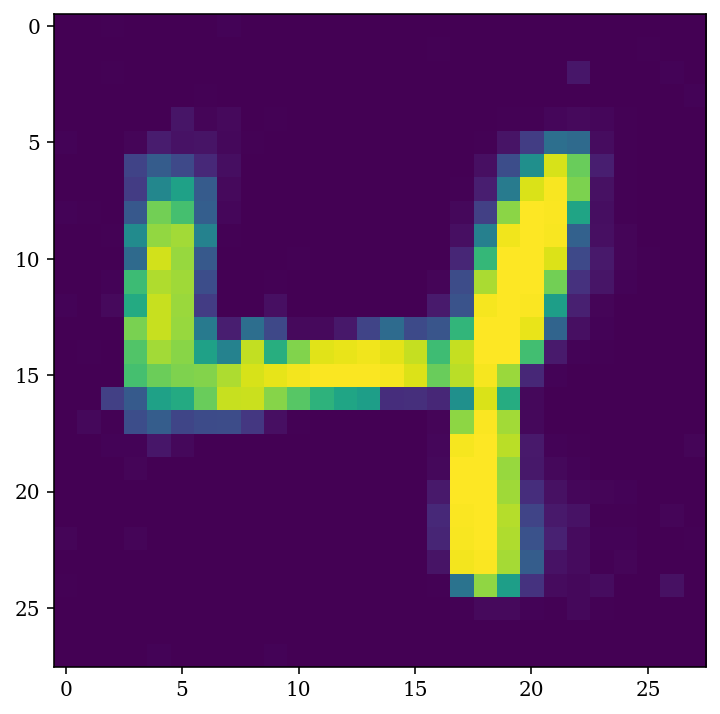

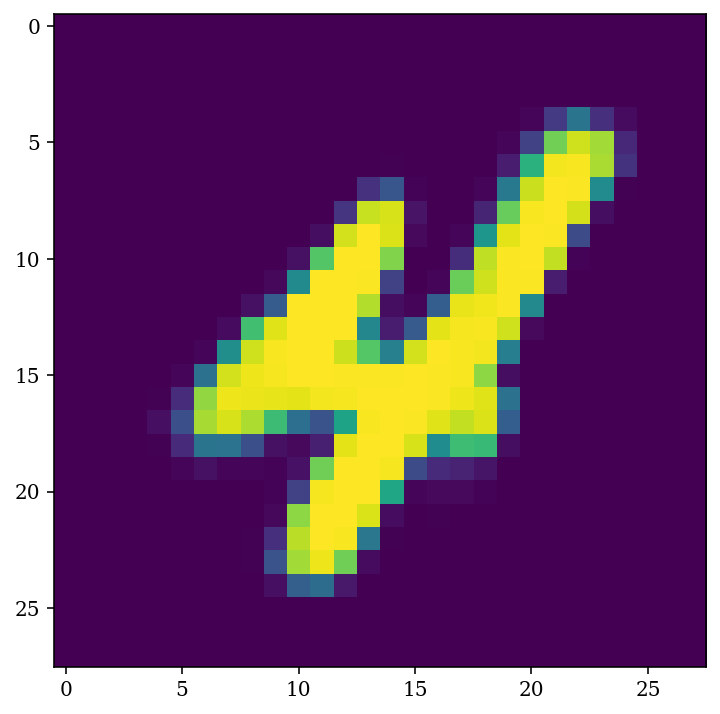

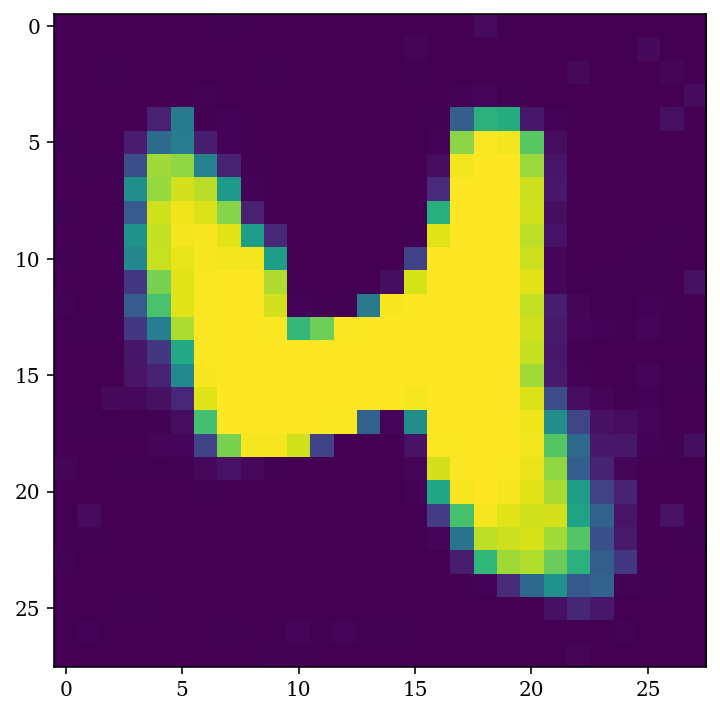

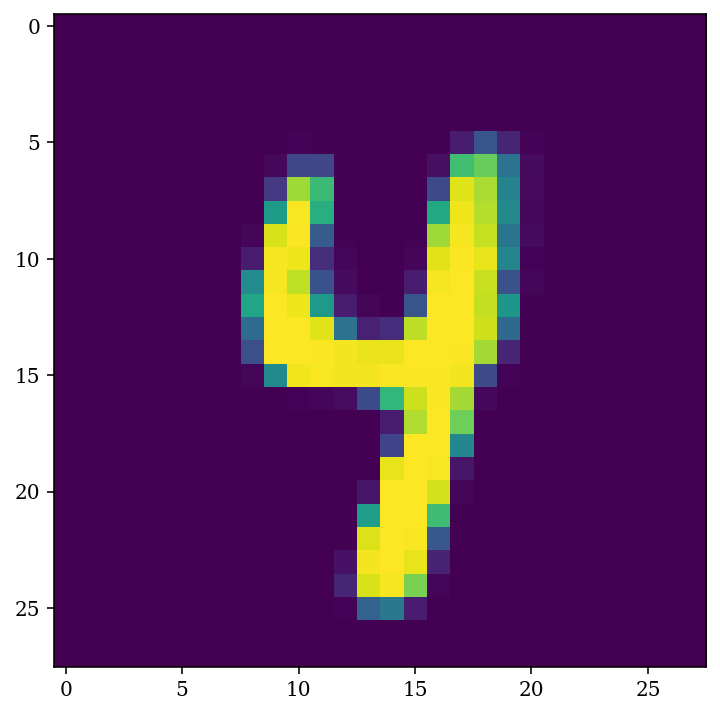

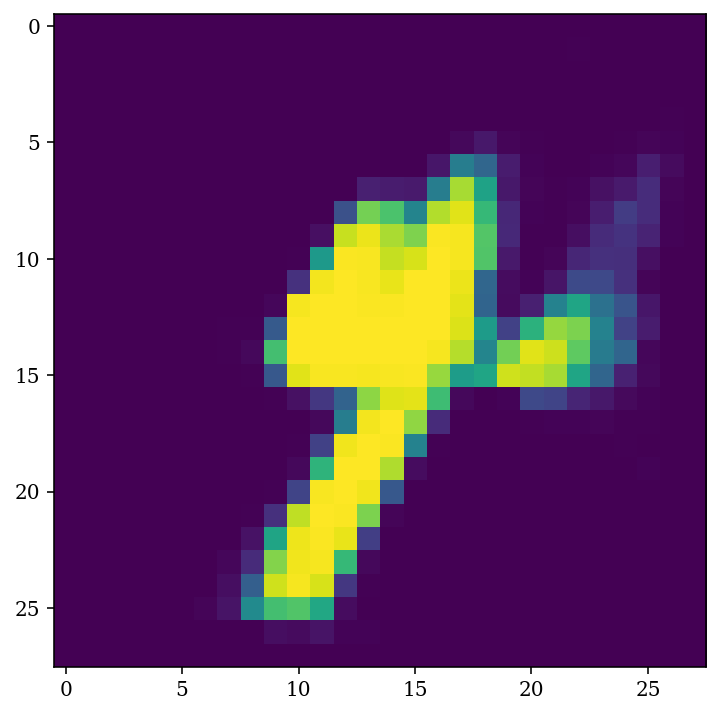

In [32]:
for i in range(5):
    plt.imshow(prob[i])
    plt.show()

In [37]:
kern  = gplvm.kernel(gplvm.X)
kern = kern.detach().cpu().numpy()

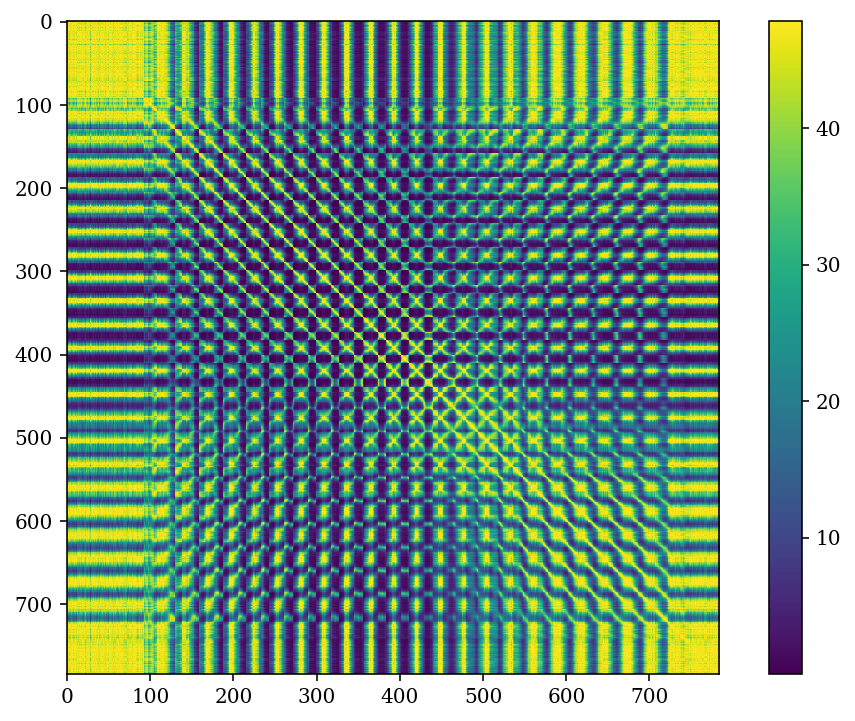

In [38]:
plt.imshow(kern)
plt.colorbar()
plt.show()

In [38]:
gplvm.X_loc.shape

torch.Size([784, 5])

In [ ]:
gplvm.kernel()

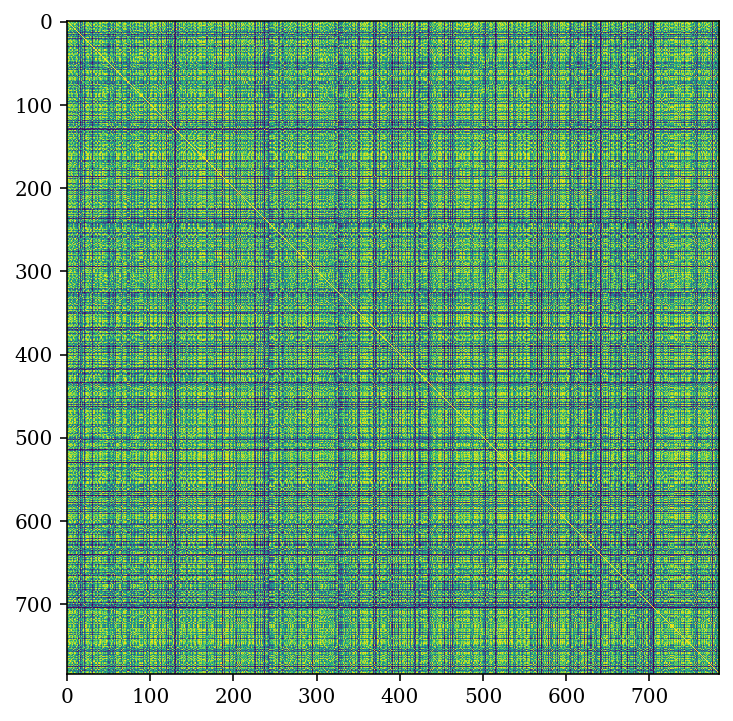

In [39]:
plt.imshow(gplvm.kernel(X_init.cuda()).detach().cpu().numpy())
plt.show()

In [234]:
hc = dist.HalfCauchy(2*torch.ones([5]))
gamma = dist.Gamma(2*torch.ones(5),.25)

In [243]:
torch.arange(1.,5)

tensor([1., 2., 3., 4.])

In [239]:
x = torch.linspace(0,50,200)

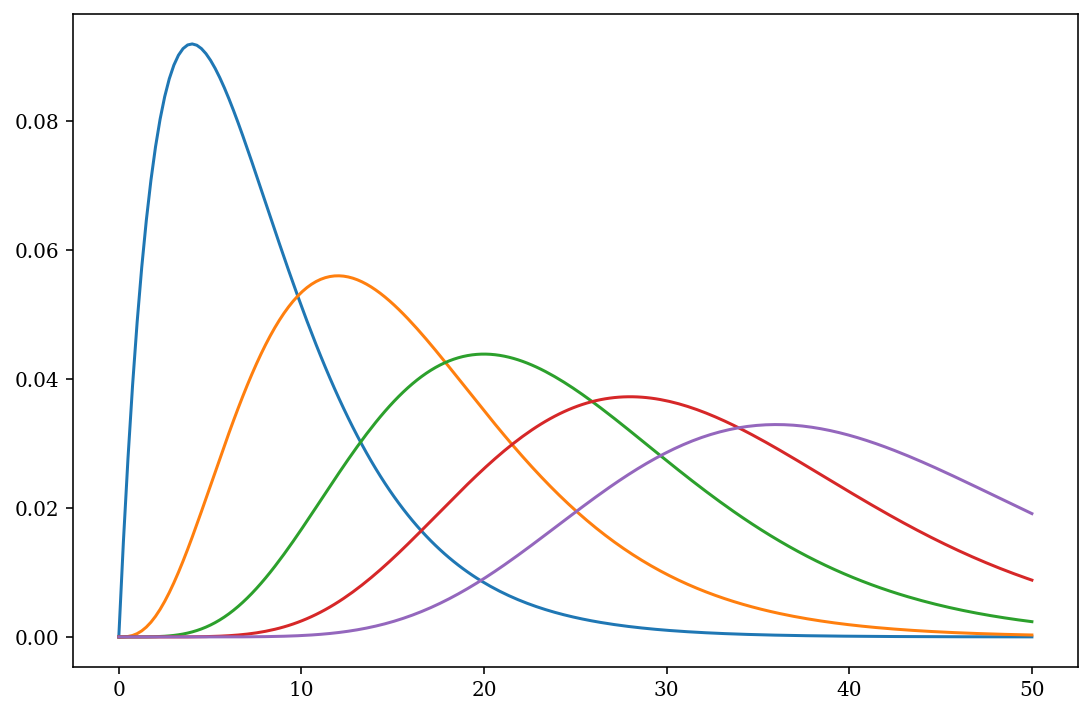

In [241]:
for i in range(5):
    pdf = dist.Gamma(2*(i+1),.25).log_prob(x).exp().numpy()
    plt.plot(np.linspace(0,50,200), pdf)
plt.show()

In [168]:
gamma.device

AttributeError: 'Gamma' object has no attribute 'device'

In [ ]:
cluster_inds = (Xout[:,0]<-5).astype(np.float)
plt.imshow(cluster_inds.reshape(28,28))
plt.colorbar()
plt.show()

In [ ]:

for i in range(latent_dim):
    fig, ax = plt.subplots(1,2,figsize=(16,8))
    ax[0].imshow(Xin[:,i].reshape(28,28))
    ax[1].imshow(Xout[:,i].reshape(28,28))
    plt.show()

### What the hell am I supposed to be doing?

$$\newcommand{\R}{\mathbb{R}} \newcommand{\N}{\mathcal{N}}$$

So in the standard GPLVM you have $N$ data points, each of which is $P$ dimensional and you learn a latent embedding for each point that is $L$ dimensional generally with $L\ll P \ll N$. In this context the function $f \sim \mathcal{GP}$ maps from $\mathbb{R}^L \rightarrow \mathbb{R}^P$. In the categorical case, where there are $K$ classes we simply change $f$ to map from $\mathbb{R}^L \rightarrow \R^{P\times K}$ and softmax along the $K$ dimension and use that in the categorical likelihood. Calling the latent variable $x$ and the observed data $y$ The categorical model is explicitly:

$$x \sim \N(0,I_L) \text{(Conventional prior but use anything)}$$
$$ f \sim \mathcal{GP} \ \ \ f: \R^L \rightarrow \R^{P\times K}$$
$$ y_i \sim \text{Cat}(\text{softmax}(f(x)_i) \ \ \forall i= 1, 2, ..., P$$


In practice this looks like inputing a $N\times P$ dataset as`gplvm.y` (techincally you need to tranpose it) and an $N\times L$ parameter matrix of initial latent points as `gplvm.X`. To test the model you put in a $N_{test} \times L$ tensor and get a $N_{test}\times P$ output.

In the case of the protein model we want to embed each residue of the protein so $N= \#$ of residues in sequence. $L$ is still arbitrarily chosen and $K=20$ (or 21 if we include skips which I think we need to for MSA data. At first pass it seems like you just transpose the data matrix compared to the original case but if you do that you end up with $P = \#$ of sequences in the alignment and a GP function that maps $\R^L \rightarrow \R^{P \times K}$ where now $P$ is a very large number and you are prediciting the probability of that residue's assignment in *each* sequence in the alignment which doesnt seem like the thing you actually want. Compared to the original case we now basically have $L \ll N \ll P$ which seems weird. 

So the question is what should be in input data (i.e. `gplvm.y`), the only thought I have it that maybe it should be the marginal probabilities of the residue having a particular value (so its shape would be $N\times K$ where each row is in the unit simplex) and then once we learn the latent variables we could approximate the joint distribution of the residues rather than just the marginals. 

In [ ]:
ss = S.numpy()**2
ss= ss/ss.sum()
plt.plot(np.cumsum(ss))
plt.show()

In [ ]:
np.argmax(ss<0.01)

In [ ]:
np.cumsum(ss)[10]

In [ ]:
pcs =  U.mm(torch.diag(S)[:,:10]).to(torch.get_default_dtype())
for i in range(10):
    pc = pcs[:,i].numpy().reshape(28,28)
    plt.imshow(pc)
    plt.show()

In [ ]:
plt.scatter(x_out_iso[:,0],x_out_iso[:,1])
plt.show()

In [ ]:
gplvm.y.shape

In [ ]:
fl, fv  = gplvm(torch.arange(0,2).unsqueeze(0).cuda())

In [ ]:
plt.imshow(fv[401].detach().cpu().numpy())
plt.show()

In [ ]:
gplvm.guide